In [1]:
import pandas as pd
import numpy as np
import pickle 
import torch
from scripts.visualisation import plot_cpg_reconstruction
import matplotlib.pyplot as plt

# Load test data

In [2]:
PATH_data = "data"
PATH_results = "logs"

with open(os.path.join(PATH_data, "chr22_overlap_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

# Train model

In [18]:
!python train_AE.py --help

usage: train_AE.py [-h] [--name NAME] [--train_file TRAIN_FILE]
                   [--val_file VAL_FILE]
                   [--hidden_layer_encoder_topology HIDDEN_LAYER_ENCODER_TOPOLOGY [HIDDEN_LAYER_ENCODER_TOPOLOGY ...]]
                   [--latentSize LATENTSIZE] [--learning_rate LEARNING_RATE]
                   [--n_epochs N_EPOCHS]

Train AE

optional arguments:
  -h, --help            show this help message and exit
  --name NAME
  --train_file TRAIN_FILE
  --val_file VAL_FILE
  --hidden_layer_encoder_topology HIDDEN_LAYER_ENCODER_TOPOLOGY [HIDDEN_LAYER_ENCODER_TOPOLOGY ...]
  --latentSize LATENTSIZE
  --learning_rate LEARNING_RATE
  --n_epochs N_EPOCHS


In [168]:
!python train_AE.py --name AE_noBatchNorm \
                    --train_file chr22_overlap_train_methyl_array.pkl \
                    --val_file chr22_overlap_val_methyl_array.pkl \
                    --hidden_layer_encoder_topology 2000 500 \
                    --latentSize 10 \
                    --learning_rate 1e-05 \
                    --n_epochs 300 \
                    --patienceEarlyStopping 100

normalAE(
  (encoder): Sequential(
    (0): Linear(in_features=4671, out_features=2000, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=2000, out_features=500, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=500, out_features=10, bias=True)
    (5): PReLU(num_parameters=1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=500, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=500, out_features=2000, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=2000, out_features=4671, bias=True)
    (5): Sigmoid()
  )
)
		Logging to logs/AE_noBatchNorm/checkpoint
cpu
Epoch: 1
Training Loss: 277048.475
Validation Loss: 35769.769
Validation loss decreased (inf --> 35769.768555).  Saving model ...
Epoch: 2
Training Loss: 249091.24
Validation Loss: 34903.751
Validation loss decreased (35769.768555 --> 34903.750977).  Saving model ...
Epoch: 3
Training Loss: 238673.508
Validation Loss: 33

# Reconstruction

In [6]:
name="AE_ReLU"
model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))
model

normalAE(
  (encoder): Sequential(
    (0): Linear(in_features=4671, out_features=2000, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=2000, out_features=500, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=50, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=2000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2000, out_features=4671, bias=True)
    (5): Sigmoid()
  )
)

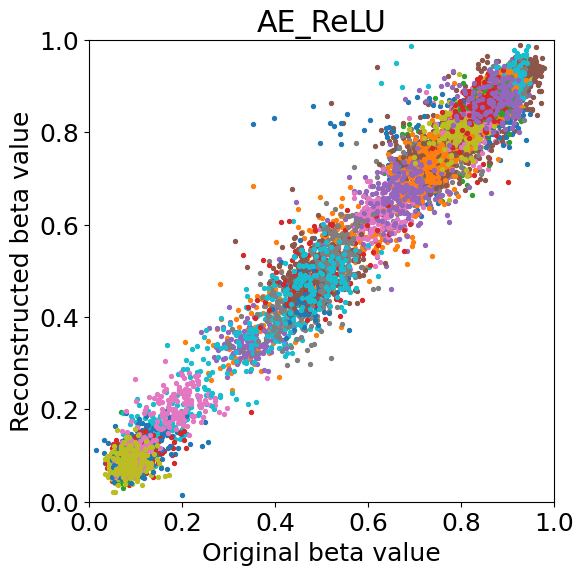

In [7]:
plot_cpg_reconstruction(model, test_tensor, title=name)

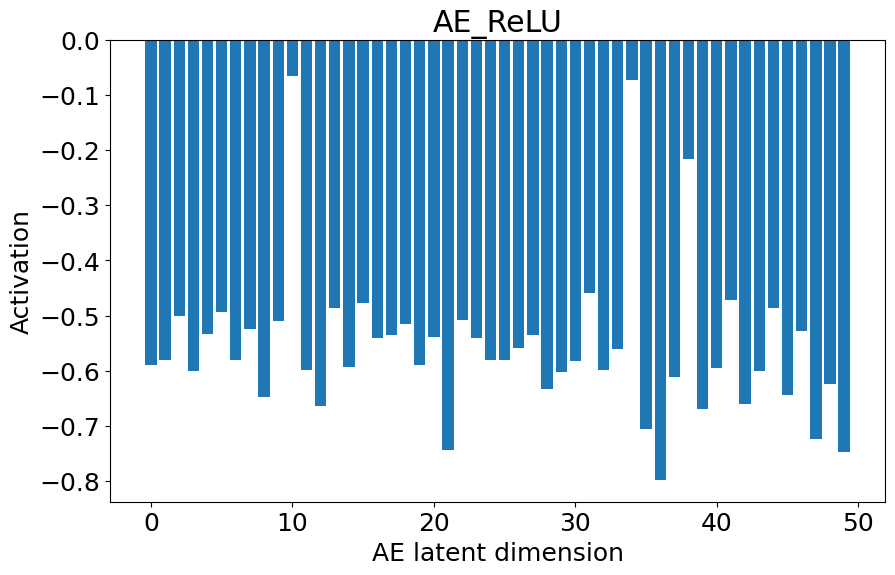

In [8]:
with torch.no_grad():
    latSpace = model.generate_embedding(test_tensor).detach().numpy()

fig, ax = plt.subplots(figsize=(10,6))
#ax.boxplot(latSpace)
#ax.bar(range(latSpace.shape[1]),latSpace.sum(axis=0))
ax.bar(range(latSpace.shape[1]),np.median(latSpace,axis=0))
ax.set_title(name)
ax.set_xlabel("AE latent dimension")
ax.set_ylabel("Activation")
plt.show()

In [15]:
latSpace

array([[ 0.02576649, -0.29599667, -0.50091815, ..., -0.7253418 ,
         0.04852225, -0.74713963],
       [-0.5459712 , -0.58037496, -0.50091815, ..., -0.6141635 ,
        -0.62355095, -0.23455766],
       [ 0.8378895 ,  0.5933609 ,  0.66253555, ..., -0.7253418 ,
         0.434117  , -0.74713963],
       ...,
       [ 0.75659204,  0.4368606 , -0.06211117, ..., -0.7253418 ,
         0.3840134 , -0.74713963],
       [ 0.611274  ,  0.2248807 ,  0.28668916, ..., -0.7253418 ,
         0.4642234 , -0.74713963],
       [ 0.25809166, -0.1186875 , -0.50091815, ..., -0.7253418 ,
         0.09380805, -0.74713963]], dtype=float32)